In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

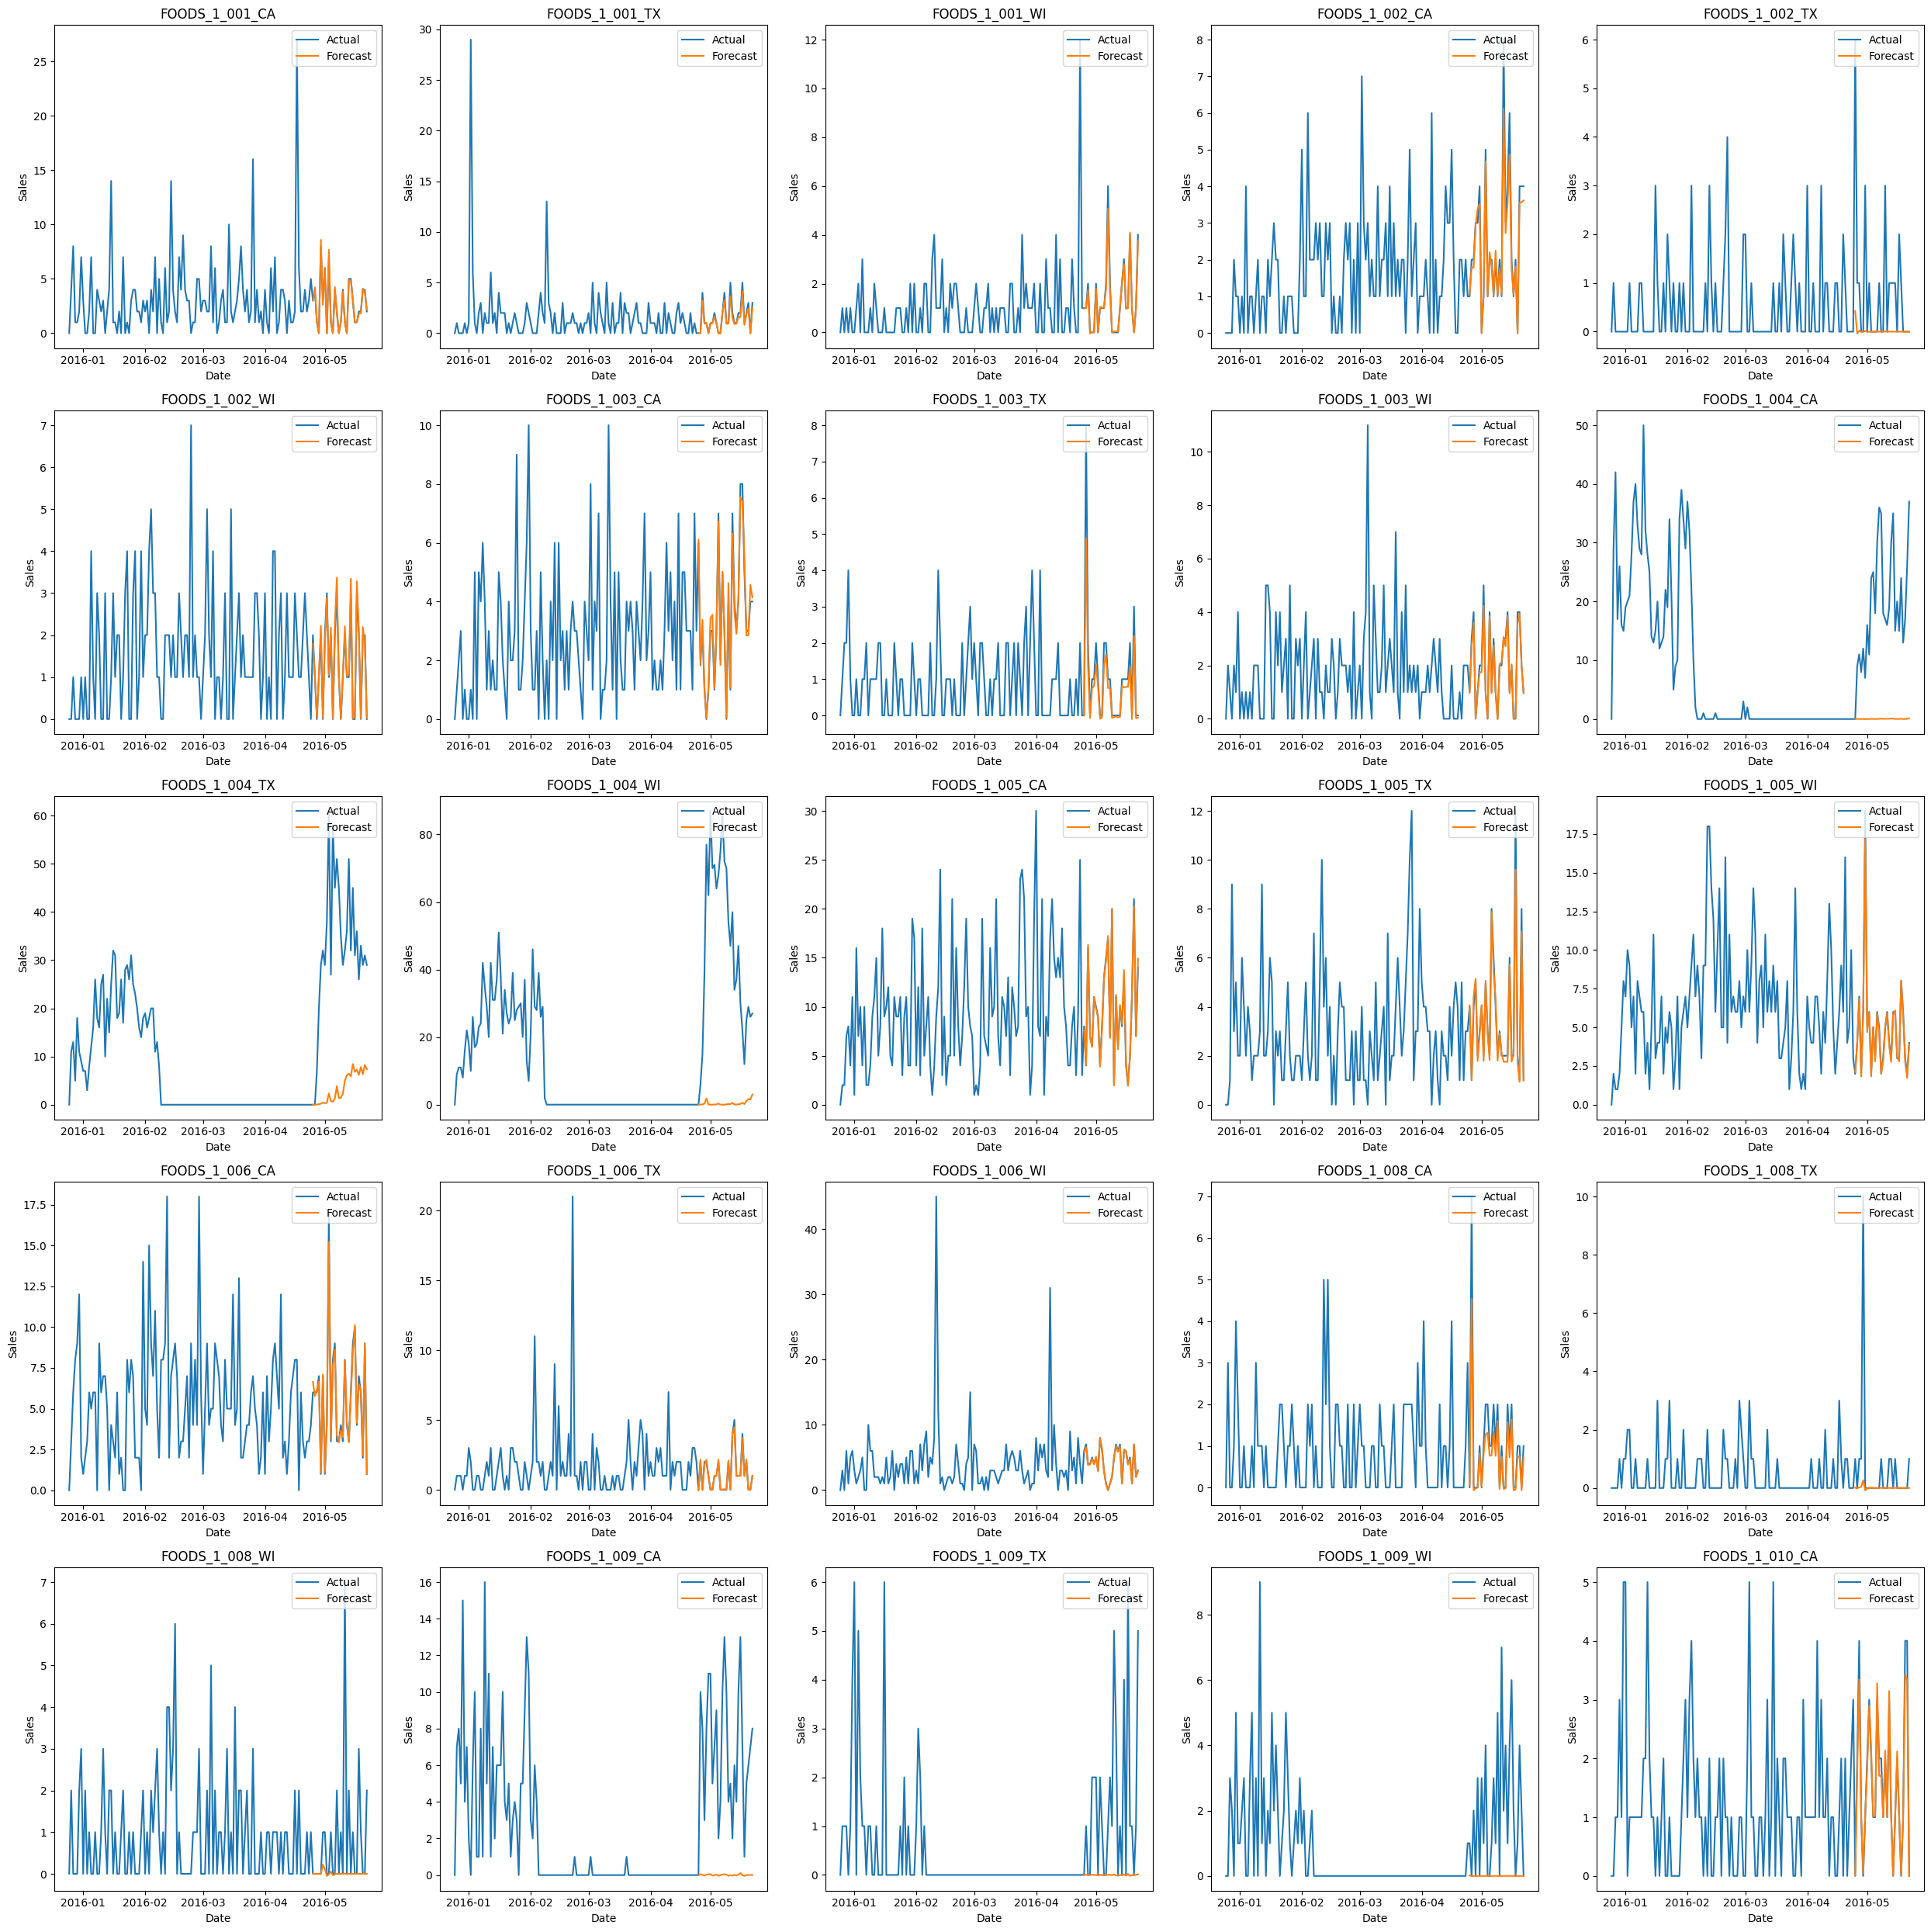

In [61]:
level_idx = 11

estimator = 'DeepAR'
ids = np.empty((0, ))
train_labels = np.empty((0, 28))
train_forecasts = np.empty((0, 28))
test_labels = np.empty((0, 28))
test_forecasts = np.empty((0, 28))

for level in range(level_idx, level_idx+1):
    level_dir = f"../result/level {level}"
    for model_dir in os.listdir(level_dir):
        if model_dir.startswith(estimator):
            model_path = os.path.join(level_dir, model_dir)
            if os.path.isdir(model_path):
                for root, dirs, files in os.walk(model_path):
                    for file in files:
                        if file.startswith('train_labels'):
                            with open(os.path.join(root, file), 'rb') as pickle_file:
                                train_labels = pd.read_pickle(pickle_file)
                                # arrays = np.array(datas)
                                # arrays = np.squeeze(arrays, axis=-1)
                                # arrays = arrays[:, -28:]
                                # train_labels = np.concatenate((train_labels, arrays), axis=0)
                        if file.startswith('train_forecasts'):
                            with open(os.path.join(root, file), 'rb') as pickle_file:
                                train_forecasts = pd.read_pickle(pickle_file)
                                # arrays = np.array([data.quantile(0.5) for data in datas])
                                # train_forecasts = np.concatenate((train_forecasts, arrays), axis=0)
                        if file.startswith('test_labels'):
                            with open(os.path.join(root, file), 'rb') as pickle_file:
                                test_labels = pd.read_pickle(pickle_file)
                                # arrays = np.array(datas)
                                # arrays = np.squeeze(arrays, axis=-1)
                                # arrays = arrays[:, -28:]
                                # test_labels = np.concatenate((test_labels, arrays), axis=0)
                        if file.startswith('test_forecasts'):
                            with open(os.path.join(root, file), 'rb') as pickle_file:
                                test_forecasts = pd.read_pickle(pickle_file)
                                # id = np.array([data.item_id for data in datas])
                                # ids = np.concatenate((ids, id), axis=0)
                                # arrays = np.array([data.quantile(0.5) for data in datas])
                                # test_forecasts = np.concatenate((test_forecasts, arrays), axis=0)

    page = 0
    graphs_per_page = 25

    start_idx = page * graphs_per_page
    end_idx = start_idx + graphs_per_page

    num_plots = min(len(test_labels[start_idx:end_idx]), graphs_per_page)
    cols = 5
    rows = (num_plots + cols - 1) // cols 
    fig, axes = plt.subplots(rows, cols, figsize=(25, 5 * rows))

    for i in range(num_plots):
        row = i // cols
        col = i % cols
        ax = axes[row, col] if rows > 1 else axes[col]
        
        ax.plot(test_labels[start_idx + i][-150:].to_timestamp(), label="Actual")
        ax.plot(pd.Series(test_forecasts[start_idx + i].quantile(0.5), index=test_forecasts[start_idx + i].start_date.to_timestamp() + pd.to_timedelta(range(len(test_forecasts[0].quantile(0.5))), unit='D')), label="Forecast")
        ax.set_title(f'{test_forecasts[start_idx + i].item_id}')
        ax.set_xlabel('Date')
        ax.set_ylabel('Sales')
        ax.legend(loc="upper right")

    for j in range(num_plots, rows * cols):
        fig.delaxes(axes.flatten()[j])

    plt.tight_layout()
    plt.show()
    plt.close()


In [62]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import pickle
import os
from tqdm import tqdm
import gc
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

def prepare_lgbm_data(df, target_col='sales_sum', window_size=28):
    features = []
    targets = []
    
    for i in range(window_size, len(df)):
        window = df.iloc[i-window_size:i]
        
        feature = {
            'sales_mean': window[target_col].mean(),
            'sales_std': window[target_col].std(),
            'sales_max': window[target_col].max(),
            'sales_min': window[target_col].min(),
            'sales_last': window[target_col].iloc[-1],
            'sales_last7_mean': window[target_col].iloc[-7:].mean(),
            'sales_last14_mean': window[target_col].iloc[-14:].mean(),
            'sales_last28_mean': window[target_col].iloc[-28:].mean(),
            
            'sales_diff_mean': np.mean(np.diff(window[target_col])),
            'sales_diff_std': np.std(np.diff(window[target_col])),
            
            'sales_lag7': window[target_col].iloc[-7] if len(window) >= 7 else 0,
            'sales_lag14': window[target_col].iloc[-14] if len(window) >= 14 else 0,
            'sales_lag28': window[target_col].iloc[-28] if len(window) >= 28 else 0,
            
            'sell_price_mean': window['sell_price_mean'].mean(),
            'sell_price_std': window['sell_price_std'].mean(),
            'sell_price_last': window['sell_price_mean'].iloc[-1],
            'sell_price_diff_mean': np.mean(np.diff(window['sell_price_mean'])),
            
            'event_count': window['event_count'].sum(),
            'has_event': 1 if window['event_count'].sum() > 0 else 0,
            
            'month': df.index[i].month,
            'day': df.index[i].day,
            'weekday': df.index[i].weekday(),
            'week': df.index[i].isocalendar()[1],
            'is_weekend': 1 if df.index[i].weekday() >= 5 else 0,
            'is_month_start': 1 if df.index[i].is_month_start else 0,
            'is_month_end': 1 if df.index[i].is_month_end else 0
        }
        
        if 'snap_CA' in df.columns:
            feature.update({
                'snap_CA': window['snap_CA'].iloc[-1],
                'snap_TX': window['snap_TX'].iloc[-1],
                'snap_WI': window['snap_WI'].iloc[-1]
            })
        
        features.append(feature)
        targets.append(df.iloc[i][target_col])
    
    return pd.DataFrame(features), np.array(targets)

def train_arima_model(train_df, series_id, level_dir):
    try:
        order = (7, 1, 7)
        
        arima_model = ARIMA(train_df['sales_sum'], order=order)
        arima_results = arima_model.fit()
        
        arima_train_pred = arima_results.fittedvalues
        arima_test_pred = arima_results.forecast(steps=28)
        
        with open(os.path.join(level_dir, f'arima_model_{series_id}.pkl'), 'wb') as f:
            pickle.dump(arima_results, f)
        
        return {
            'train': arima_train_pred,
            'test': arima_test_pred,
            'model': arima_results
        }
    
    except Exception as e:
        print(f"ARIMA failed for series {series_id}: {str(e)}")
        return None

def train_lgbm_model(train_df, series_id, level_dir):
    try:
        X_train, y_train = prepare_lgbm_data(train_df)
        
        params = {
            'objective': 'regression',
            'metric': 'rmse',
            'boosting_type': 'gbdt',
            'n_estimators': 1000,
            'learning_rate': 0.05,
            'num_leaves': 31,
            'min_child_samples': 20,
            'subsample': 0.8,
            'colsample_bytree': 0.8,
            'reg_alpha': 0.1,
            'reg_lambda': 0.1,
            'random_state': 42
        }
        
        lgbm_model = LGBMRegressor(**params)
        lgbm_model.fit(
            X_train, y_train,
            eval_set=[(X_train, y_train)],
            eval_metric='rmse',
            early_stopping_rounds=50,
            verbose=False
        )
        
        lgbm_train_pred = lgbm_model.predict(X_train)
        
        test_df = train_df.copy()
        lgbm_test_pred = []
        
        for i in range(28):
            X_test, _ = prepare_lgbm_data(test_df)
            pred = lgbm_model.predict(X_test.iloc[[-1]])
            lgbm_test_pred.append(pred[0])
            
            next_date = test_df.index[-1] + pd.Timedelta(days=1)
            new_row = pd.DataFrame({
                'sales_sum': pred[0],
                'event_count': test_df['event_count'].iloc[-1],
                'sell_price_mean': test_df['sell_price_mean'].iloc[-1],
                'sell_price_std': test_df['sell_price_std'].iloc[-1]
            }, index=[next_date])
            
            test_df = pd.concat([test_df, new_row])
        
        with open(os.path.join(level_dir, f'lgbm_model_{series_id}.pkl'), 'wb') as f:
            pickle.dump(lgbm_model, f)
        
        return {
            'train': lgbm_train_pred,
            'test': np.array(lgbm_test_pred),
            'model': lgbm_model,
            'feature_importance': pd.DataFrame({
                'feature': X_train.columns,
                'importance': lgbm_model.feature_importances_
            }).sort_values('importance', ascending=False)
        }
    
    except Exception as e:
        print(f"LightGBM failed for series {series_id}: {str(e)}")
        return None

def evaluate_predictions(true_values, predictions, model_name, phase):
    metrics = {
        'mse': mean_squared_error(true_values, predictions),
        'rmse': np.sqrt(mean_squared_error(true_values, predictions)),
        'mae': mean_absolute_error(true_values, predictions),
        'mape': mean_absolute_percentage_error(true_values, predictions) * 100
    }
    
    print(f"\n{model_name} - {phase} Metrics:")
    for metric_name, value in metrics.items():
        print(f"{metric_name.upper()}: {value:.4f}")
    
    return metrics

def train_traditional_models(level_idx, save_dir='../result/traditional'):
    print(f"\n{'='*20} Level {level_idx} {'='*20}")
    start_time = datetime.now()
    
    level_dir = os.path.join(save_dir, f'level_{level_idx}')
    os.makedirs(level_dir, exist_ok=True)
    
    print("\nLoading dataset...")
    with open(os.path.join('../dataset', f'dataset_level_{level_idx}.pkl'), 'rb') as f:
        dataset = pickle.load(f)
    
    results = {
        'arima': {'train': {}, 'test': {}, 'metrics': {'train': {}, 'test': {}}},
        'lgbm': {'train': {}, 'test': {}, 'metrics': {'train': {}, 'test': {}}, 'feature_importance': {}}
    }
    
    for id_idx, (train_data, test_data) in enumerate(zip(dataset['train'], dataset['test'])):
        series_id = train_data['item_id']
        print(f"\nProcessing series {id_idx + 1}/{len(dataset['train'])}: {series_id}")
        
        train_df = pd.DataFrame({
            'sales_sum': train_data['target'],
            'event_count': train_data['feat_dynamic_real'][-1],
            'sell_price_mean': train_data['feat_dynamic_real'][-8],
            'sell_price_std': train_data['feat_dynamic_real'][-7],
            'snap_CA': train_data['feat_dynamic_cat'][0],
            'snap_TX': train_data['feat_dynamic_cat'][1],
            'snap_WI': train_data['feat_dynamic_cat'][2]
        }, index=pd.date_range(start=train_data['start'], periods=len(train_data['target']), freq='D'))
        
        print("\nTraining ARIMA...")
        arima_results = train_arima_model(train_df, series_id, level_dir)
        if arima_results is not None:
            results['arima']['train'][series_id] = arima_results['train']
            results['arima']['test'][series_id] = arima_results['test']
            
            results['arima']['metrics']['train'][series_id] = evaluate_predictions(
                train_data['target'], 
                arima_results['train'],
                'ARIMA',
                'Train'
            )
            results['arima']['metrics']['test'][series_id] = evaluate_predictions(
                test_data['target'][-28:],
                arima_results['test'],
                'ARIMA',
                'Test'
            )
        
        print("\nTraining LightGBM...")
        lgbm_results = train_lgbm_model(train_df, series_id, level_dir)
        if lgbm_results is not None:
            results['lgbm']['train'][series_id] = lgbm_results['train']
            results['lgbm']['test'][series_id] = lgbm_results['test']
            results['lgbm']['feature_importance'][series_id] = lgbm_results['feature_importance']
            
            results['lgbm']['metrics']['train'][series_id] = evaluate_predictions(
                train_data['target'][28:],
                lgbm_results['train'],
                'LightGBM',
                'Train'
            )
            results['lgbm']['metrics']['test'][series_id] = evaluate_predictions(
                test_data['target'][-28:],
                lgbm_results['test'],
                'LightGBM',
                'Test'
            )
        
        gc.collect()
    
    print("\nSaving results...")
    results_file = os.path.join(level_dir, f'traditional_results_level_{level_idx}.pkl')
    with open(results_file, 'wb') as f:
        pickle.dump(results, f)
    
    print("\nOverall Performance Summary:")
    for model in ['arima', 'lgbm']:
        print(f"\n{model.upper()} Average Metrics:")
        
        train_metrics = {
            metric: np.mean([metrics[metric] 
                           for metrics in results[model]['metrics']['train'].values()])
            for metric in ['mse', 'rmse', 'mae', 'mape']
        }
        print("\nTrain:")
        for metric, value in train_metrics.items():
            print(f"{metric.upper()}: {value:.4f}")
        
        test_metrics = {
            metric: np.mean([metrics[metric] 
                           for metrics in results[model]['metrics']['test'].values()])
            for metric in ['mse', 'rmse', 'mae', 'mape']
        }
        print("\nTest:")
        for metric, value in test_metrics.items():
            print(f"{metric.upper()}: {value:.4f}")
    
    if results['lgbm']['feature_importance']:
        print("\nAnalyzing LightGBM Feature Importance...")
        
        all_features = pd.concat(results['lgbm']['feature_importance'].values())
        avg_importance = all_features.groupby('feature')['importance'].mean().sort_values(ascending=False)
        
        print("\nTop 10 Most Important Features:")
        for feature, importance in avg_importance.head(10).items():
            print(f"{feature}: {importance:.4f}")
        
        importance_file = os.path.join(level_dir, f'feature_importance_level_{level_idx}.csv')
        avg_importance.to_csv(importance_file)
    
    end_time = datetime.now()
    execution_time = end_time - start_time
    print(f"\nTotal execution time: {execution_time}")

def plot_predictions(results, dataset, level_idx, save_dir='../result/traditional'):
    """예측 결과 시각화
    
    Args:
        results (dict): 모델 예측 결과
        dataset (dict): 원본 데이터셋
        level_idx (int): 데이터 레벨 인덱스
        save_dir (str): 결과 저장 경로
    """
    import matplotlib.pyplot as plt
    
    level_dir = os.path.join(save_dir, f'level_{level_idx}')
    plots_dir = os.path.join(level_dir, 'plots')
    os.makedirs(plots_dir, exist_ok=True)
    
    for id_idx, (train_data, test_data) in enumerate(zip(dataset['train'], dataset['test'])):
        series_id = train_data['item_id']
        
        # 실제 데이터의 날짜 인덱스 생성
        dates = pd.date_range(start=train_data['start'], periods=len(train_data['target']), freq='D')
        actual_values = pd.Series(train_data['target'], index=dates)
        
        # 그래프 생성
        plt.figure(figsize=(15, 7))
        
        # 실제 값 플롯 (마지막 100일)
        plt.plot(actual_values[-100:], label='Actual', color='black', linewidth=2)
        
        # ARIMA 예측 플롯
        if series_id in results['arima']['test']:
            arima_dates = pd.date_range(start=dates[-28], periods=28, freq='D')
            plt.plot(arima_dates, results['arima']['test'][series_id], 
                    label='ARIMA', color='blue', linestyle='--')
        
        # LightGBM 예측 플롯
        if series_id in results['lgbm']['test']:
            lgbm_dates = pd.date_range(start=dates[-28], periods=28, freq='D')
            plt.plot(lgbm_dates, results['lgbm']['test'][series_id], 
                    label='LightGBM', color='green', linestyle='--')
        
        # 그래프 설정
        plt.title(f'Series {series_id} - Last 100 Days and 28 Days Forecast')
        plt.xlabel('Date')
        plt.ylabel('Sales')
        plt.legend()
        plt.grid(True)
        
        # 그래프 저장
        plt.savefig(os.path.join(plots_dir, f'series_{series_id}.png'))
        plt.close()
        
        # 진행상황 출력
        if id_idx % 10 == 0:
            print(f"Plotted {id_idx + 1}/{len(dataset['train'])} series")

In [63]:
import pandas as pd
import numpy as np
import pickle
import os
from datetime import datetime

def convert_gluonts_dataset(dataset_path, save_dir='../data/traditional'):
    """GluonTS 데이터셋을 전통적인 시계열 모델용 데이터프레임으로 변환
    
    Args:
        dataset_path (str): GluonTS 데이터셋 경로
        save_dir (str): 변환된, 데이터셋 저장 경로
    """
    # 저장 디렉토리 생성
    os.makedirs(save_dir, exist_ok=True)
    
    # GluonTS 데이터셋 로드
    with open(dataset_path, 'rb') as f:
        gluon_dataset = pickle.load(f)
    
    # 변환된 데이터를 저장할 딕셔너리
    converted_data = {
        'train': {},
        'test': {}
    }
    
    # 훈련 데이터 변환
    for item in gluon_dataset['train']:
        series_id = item['item_id']
        start_date = item['start'].to_timestamp()
        
        # 기본 시계열 데이터
        df = pd.DataFrame({
            'sales_sum': item['target'],
            'date': pd.date_range(start=start_date, periods=len(item['target']), freq='D')
        }).set_index('date')
        
        # 동적 실수형 특성 추가
        feature_names = [
            'sales_mean', 'sales_std', 'sales_max', 'sales_min', 'sales_diff_mean',
            'sales_lag1_mean', 'sales_lag7_mean', 'sales_lag28_mean',
            'sales_rolling7_mean', 'sales_rolling28_mean', 'sales_rolling7_diff_mean', 'sales_rolling28_diff_mean',
            'release_mean', 'out_of_stock_mean',
            'sell_price_mean', 'sell_price_std', 'sell_price_max', 'sell_price_min', 'sell_price_diff_mean',
            'sell_price_lag_mean', 'sell_price_rolling_mean', 'sell_price_rolling_diff_mean',
            'sell_price_in_store_mean',
            'year_delta', 'quarter_sin', 'quarter_cos', 'month_sin', 'month_cos',
            'day_sin', 'day_cos', 'weekday_sin', 'weekday_cos',
            'event_count'
        ]
        
        for idx, feature_name in enumerate(feature_names):
            df[feature_name] = item['feat_dynamic_real'][idx]
        
        # 동적 범주형 특성 추가
        cat_feature_names = [
            'snap_CA', 'snap_TX', 'snap_WI',
            'event_name_1_enc', 'event_name_2_enc',
            'event_type_1_enc', 'event_type_2_enc'
        ]
        
        for idx, feature_name in enumerate(cat_feature_names):
            df[feature_name] = item['feat_dynamic_cat'][idx]
        
        converted_data['train'][series_id] = df
    
    # 테스트 데이터 변환 (훈련 데이터와 동일한 과정)
    for item in gluon_dataset['test']:
        series_id = item['item_id']
        start_date = item['start'].to_timestamp()
        
        df = pd.DataFrame({
            'sales_sum': item['target'],
            'date': pd.date_range(start=start_date, periods=len(item['target']), freq='D')
        }).set_index('date')
        
        for idx, feature_name in enumerate(feature_names):
            df[feature_name] = item['feat_dynamic_real'][idx]
        
        for idx, feature_name in enumerate(cat_feature_names):
            df[feature_name] = item['feat_dynamic_cat'][idx]
        
        converted_data['test'][series_id] = df
    
    # 변환된 데이터셋 저장
    level_idx = int(dataset_path.split('_')[-1].split('.')[0])
    output_path = os.path.join(save_dir, f'traditional_dataset_level_{level_idx}.pkl')
    
    with open(output_path, 'wb') as f:
        pickle.dump(converted_data, f)
    
    print(f"Converted dataset saved to: {output_path}")
    print(f"Number of series - Train: {len(converted_data['train'])}, Test: {len(converted_data['test'])}")
    
    return converted_data

if __name__ == "__main__":
    # 사용 예시
    level_idx = 8  # 원하는 레벨 선택
    dataset_path = f'../dataset/dataset_level_{level_idx}.pkl'
    converted_data = convert_gluonts_dataset(dataset_path)

FileNotFoundError: [Errno 2] No such file or directory: '../dataset/dataset_level_8.pkl'

In [ ]:
if __name__ == "__main__":
    # 사용 예시
    level_idx = 8  # 원하는 레벨 선택
    
    # 데이터 로드
    with open(os.path.join('../dataset', f'dataset_level_{level_idx}.pkl'), 'rb') as f:
        dataset = pickle.load(f)
    
    # 결과 로드
    with open(os.path.join(f'../result/traditional/level_{level_idx}', 
                          f'traditional_results_level_{level_idx}.pkl'), 'rb') as f:
        results = pickle.load(f)
    
    # 시각화 실행
    plot_predictions(results, dataset, level_idx)